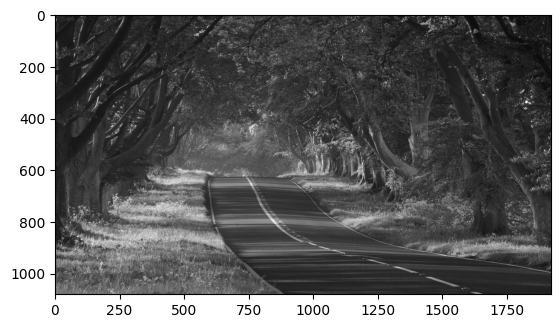

In [105]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import dct, idct

img = cv2.imread('imgs/highway.jpg', cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap='gray')

In [106]:
def DCT(img):
    Y = np.zeros(img.shape)

    U = img.shape[0]//8
    V = img.shape[1]//8

    for u in range(U):
        for v in range(V):
            img_blck = img[u*8: u*8 + 8, v*8: v*8 + 8]
            Y[u*8: u*8 + 8, v*8: v*8 + 8] = dct(dct(img_blck, axis=0, norm='ortho'), axis=1, norm='ortho')
    
    return Y

quantization = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99],
])

def quant_DCT(Y, aplha_filter=.2):
    Y_quant = np.zeros(img.shape)
    U = img.shape[0]//8
    V = img.shape[1]//8

    for u in range(U):
        for v in range(V):
            Y_quant[u*8 : u*8 + 8, v*8 : v*8 + 8] = Y[u*8 : u*8 + 8, v*8 : v*8 + 8] / quantization
            Y_quant[u*8 : u*8 + 8, v*8 : v*8 + 8] *= np.abs(Y_quant[u*8 : u*8 + 8, v*8 : v*8 + 8]) >= aplha_filter
    
    return Y_quant

def dequant_DCT(Y_quant):
    U = Y_quant.shape[0]//8
    V = Y_quant.shape[1]//8
    Y_dequant = np.zeros(Y_quant.shape)
    
    for u in range(U):
        for v in range(V):
            Y_dequant[u*8 : u*8 + 8, v*8 : v*8 + 8] = Y_quant[u*8 : u*8 + 8, v*8 : v*8 + 8] * quantization
    
    return Y_dequant

def iDCT(Y):

    U = Y.shape[0]//8
    V = Y.shape[1]//8
    img_rec = np.zeros(Y.shape)
    for u in range(U):
        for v in range(V):
            img_rec[u*8 : u*8 + 8, v*8 : v*8 + 8] = idct(idct(Y[u*8 : u*8 + 8, v*8 : v*8 + 8], axis=0, norm='ortho'), axis=1, norm='ortho')
    
    return img_rec

# Compress


## DCT

(array([[0.000e+00, 5.000e+00, 9.390e+02, ..., 1.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 1.800e+01, 1.061e+03, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [1.000e+00, 7.000e+00, 1.069e+03, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        ...,
        [0.000e+00, 0.000e+00, 1.080e+03, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 0.000e+00, 1.080e+03, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 0.000e+00, 1.080e+03, ..., 0.000e+00, 0.000e+00,
         0.000e+00]]),
 array([-555.95526692, -320.07224023,  -84.18921353,  151.69381316,
         387.57683985,  623.45986654,  859.34289323, 1095.22591992,
        1331.10894662, 1566.99197331, 1802.875     ]),
 <a list of 1920 BarContainer objects>)

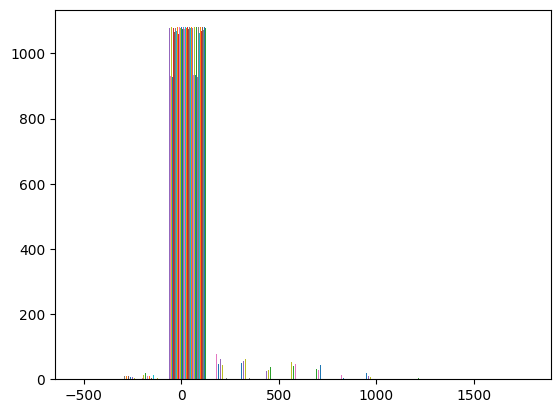

In [107]:
Y = DCT(img)
plt.hist(Y)

## Quantizando

(array([[ 0.,  2., 36., ...,  2.,  0.,  0.],
        [ 0.,  3., 83., ...,  0.,  0.,  0.],
        [ 1.,  1., 40., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([-50.5413879 , -34.21928036, -17.89717282,  -1.57506528,
         14.74704226,  31.0691498 ,  47.39125734,  63.71336488,
         80.03547242,  96.35757996, 112.6796875 ]),
 <a list of 1920 BarContainer objects>)

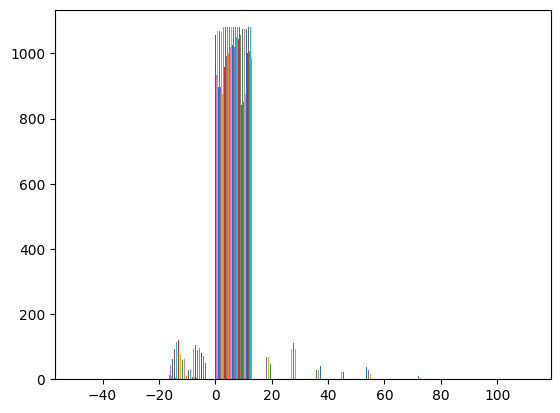

In [108]:
Y_quant = quant_DCT(Y)
plt.hist(Y_quant)

## Huffman

(733411, 365092, 733411, 2073600)

# Unconpress

## Huffman

## Dequantizando

In [110]:

Y_dequant = dequant_DCT(Y_quant)

## Transformada inversa

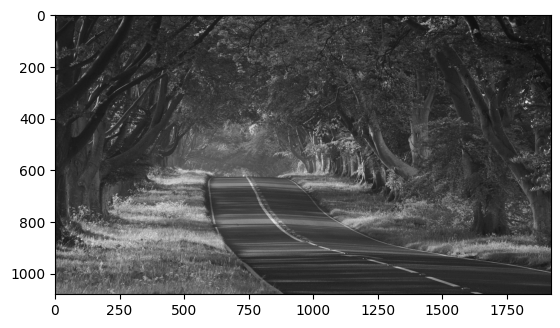

In [111]:
img_rec = iDCT(Y_dequant)
plt.imshow((img_rec), cmap='gray')


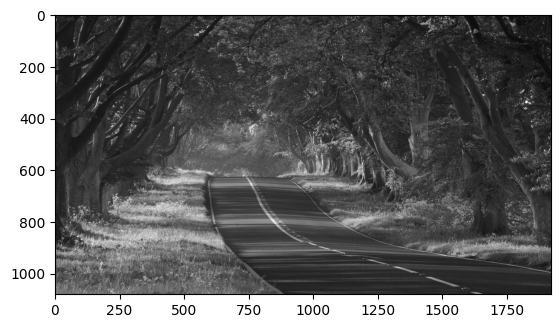

In [112]:
plt.imshow((img), cmap='gray')

# Análises


In [116]:
print(f'MSE: {((img - img_rec)**2).sum()/img.size}')
print(f'ME: {np.abs(img - img_rec).max()}')

MSE: 0.4607469380612193
ME: 8.360938195271615


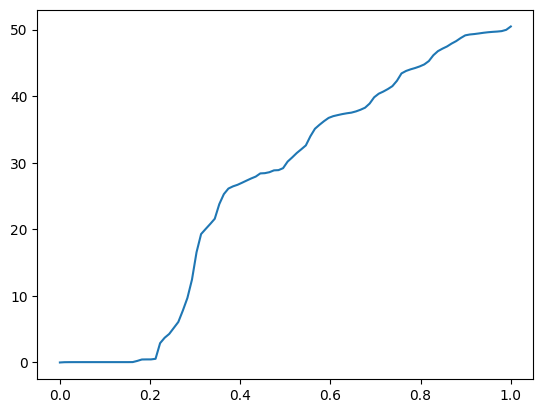

In [120]:
#escolha de filtro
((Y_quant >= .2).sum(), (Y_quant >= 1).sum(), Y_quant.size)

filtros = np.linspace(0, 1, num=100)
MSEs = np.zeros(filtros.size)

for i in range(filtros.size):
    MSEs[i] = (  (iDCT(dequant_DCT(quant_DCT(Y, aplha_filter=filtros[i]))) - img)**2  ).sum()/img.size

plt.plot(filtros, MSEs)

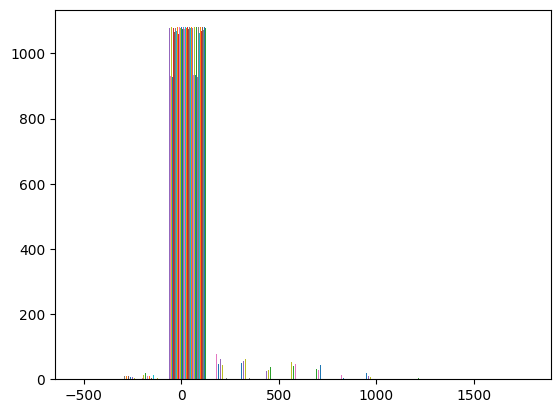

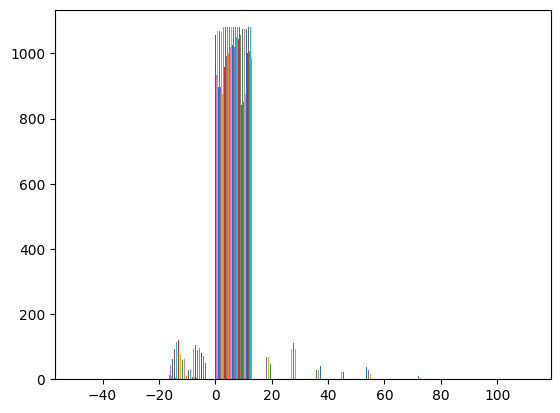

In [123]:
# histogramas para huffman
# observe o eixo-x
plt.hist(Y)
plt.show()
plt.hist(Y_quant)
plt.show()